This jupyter notebook contains some of the codes and calculations associated with our recent paper: "The VLT-MUSE and ALMA view of the MACS 1931.8-2635 brightest cluster galaxy" -Ciocan B. I. , Ziegler, B. L. , Verdugo, M. , Papaderos, P. , Fogarty, K. , Donahue, M. , and Postman, M.

## Ionisation sources: how to plot BPT diagnostic diagram together with predictions  fully radiative shock models

shock model grids:  Alarie et al. (2019)  data-base

In [30]:
import os
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table,join
from astropy.wcs import WCS
import math
from scipy.stats import gaussian_kde


Lodad your table with flux measurements for each spaxel of the data cube, as provided by FADO and apply your SNR criterium

In [35]:
table=Table.read("/Users/biancaciocan/Documents/M1931_BCG_PROJECT/M1931_results_FADO_python/FADO_joned_finito.txt",delimiter=" ",format='ascii', guess=False)

SN_Ha=table["SN_Ha"]
SN_Ha_cont_red=table["SN_Ha_cont_red"]
SN_Ha_cont_blue=table["SN_Ha_cont_blue"]

SN_Hb=table["SN_Hb"]
SN_Hb_cont_red=table["SN_Hb_cont_red"]
SN_Hb_cont_blue=table["SN_Hb_cont_blue"]

SN_OIII=table["SN_OIII"]
SN_OIII_cont_red=table["SN_OIII_cont_red"]
SN_OIII_cont_blue=table["SN_OIII_cont_blue"]


SN_NII=table["SN_NII"]
SN_NII_cont_red=table["SN_NII_cont_red"]
SN_NII_cont_blue=table["SN_NII_cont_blue"]

Halpha = table['163'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)]  
OIII_5006A = table['111'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)]   
Hbeta = table['95'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)]   
SII_6716A = table['175'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)]   
SII_6730A = table['179'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)]   
NII_6583A = table['167'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)]  
OI_6300A=table['147'][(SN_OIII>SN_OIII_cont_blue)&(SN_OIII>SN_OIII_cont_red)&(SN_Hb>SN_Hb_cont_red)&(SN_Hb>SN_Hb_cont_blue)&(SN_Ha>SN_Ha_cont_blue)&(SN_Ha>SN_Ha_cont_red)&(SN_NII>SN_NII_cont_red)& (SN_OIII>10) & (SN_NII>10) & (SN_Ha>10)& (SN_Hb>10) &(SN_SII_6718>10)&(SN_SII_6732>10)] 



NIIHa = np.log10(  NII_6583A / Halpha ) 
OIIIHb = np.log10( OIII_5006A /  Hbeta )  


/Users/biancaciocan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in log10


Plot BPT diagram:
    

/Users/biancaciocan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


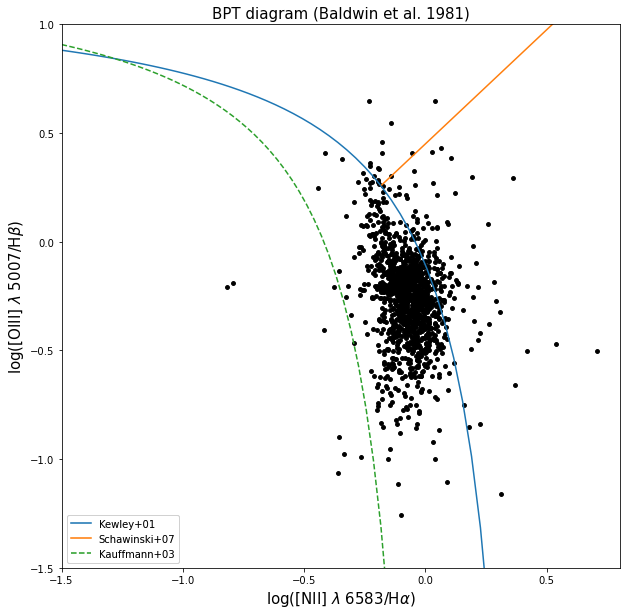

In [36]:
fig, ax = plt.subplots(facecolor='white', figsize=(10,10))


Xmin, Xmax         = -1.5, 0.8  
Ymin, Ymax         = -1.5, 1  

X = np.linspace(-1.5,0.3)
Y = (0.61/( X  - 0.47  )) + 1.19
 
a = np.linspace(-0.180,1.5)
b = 1.05*a + 0.45

c = np.linspace(-1.5,0.)
d = 0.61/(c -0.05) + 1.3

for i in range(1,len(NIIHa)):
  if math.isnan(NIIHa[i]):
    NIIHa[i] = NIIHa[i-1]

for i in range(1,len(OIIIHb)):
  if math.isnan(OIIIHb[i]):
    OIIIHb[i] = OIIIHb[i-1]

xy = np.vstack([NIIHa,OIIIHb])
z = gaussian_kde(xy)(xy)


muse=plt.scatter(NIIHa,OIIIHb, marker='o',s=15,color='black')


Kewley = plt.plot(X,   Y, '-'   )  
Schwinski = plt.plot(Xx, Yy, '-')  
Kaufmann = plt.plot(Xk, Yk, '--')  
plt.xlabel(r'log([NII] $\lambda$ 6583/H$\alpha$)', fontsize=15)
plt.ylabel(r'log([OIII] $\lambda$ 5007/H$\beta$)',fontsize=15)
plt.title("BPT diagram (Baldwin et al. 1981)",fontsize=15)
plt.ylim(Ymin, Ymax)
plt.xlim(Xmin, Xmax)
leg1=plt.legend([Kewley,Schwinski,Kaufmann],      
            labels=['Kewley+01','Schawinski+07','Kauffmann+03'],    
            loc="lower left")
plt.gca().add_artist(leg1)


So now we need to connect to the 3mdb data base in order to use fully radiative shock grids, it works easy in terminal writing the following:
    
export MdB_HOST='3mdb.astro.unam.mx'<br>
export MdB_USER='OVN_user'<br>
export MdB_PASSWD='oiii5007'<br>
export MdB_PORT='3306'<br>
export MdB_DBs='3MdBs'<br>
export MdB_DBp='3MdB'<br>
export MdB_DB_17='3MdB_17'<br>


You can find the documentation on: https://sites.google.com/site/mexicanmillionmodels/

In [ ]:
host = os.environ['MdB_HOST']
user = os.environ['MdB_USER']
passwd = os.environ['MdB_PASSWD']
port = os.environ['MdB_PORT']
                                
# Connect to the database
db = pymysql.connect(host=host, user=user, passwd=passwd, port=int(port), db='3MdBs')
                                
# Use pandas to receive the infos
result = pd.read_sql("Select ModelID from shock_params;", con=db)
                            
#SQL request with pandas

result = pd.read_sql("""SELECT shock_params.shck_vel AS shck_vel, 
                        emis_VI.OIII_5007/emis_VI.HI_4861 AS OIII_Hb
                        FROM shock_params 
                        INNER JOIN emis_VI ON emis_VI.ModelID=shock_params.ModelID
                        INNER JOIN abundances ON abundances.AbundID=shock_params.AbundID
                        WHERE emis_VI.model_type='shock' 
                        AND abundances.name='Allen2008_Solar'
                        AND shock_params.ref='Allen08'
                        AND shock_params.shck_vel BETWEEN 100 AND 1000
                        AND shock_params.mag_fld=1
                        AND shock_params.preshck_dens=10
                        ORDER BY shck_vel;""", con=db)


from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls="-", color="red", lw=1,label="solar metallicity")]

leg2=plt.legend(handles=custom_lines,loc="upper left")
plt.gca().add_artist(leg2)


for B in np.unique(result.mag_fld):
    idx = np.where(result.mag_fld==B)
    ax.plot(result.NII6583_Hb[idx[0]], result.OIII5007_Hb[idx[0]], color='red', linewidth=1)

for v in np.unique(result.shck_vel):
    idx = np.where(result.shck_vel==v)
    ax.plot(result.NII6583_Hb[idx[0]], result.OIII5007_Hb[idx[0]], color='red', linewidth=1)


plt.show()